In [1]:
#importar librerias necesarias
from mesa import Agent, Model 

#necesitamos que al inicio esten todos los robots en el mismo punto
from mesa.space import MultiGrid
from mesa.space import SingleGrid

#todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

#obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import time
import datetime

In [2]:
#importaciones para el servidor
from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

In [3]:
height = 0
width = 0
puntoGeneracion = (0, 0)
mapaInicial = []
mapaActual = []
basurasPos = []
totalBasura = 0
papelera = (0,0)

In [4]:
def leerTxt():
  global height, width, puntoGeneracion, papelera
  archivo = "input1.txt"
  matriz = []

  with open(archivo, 'r') as f:
      lineas = f.readlines()

  # Obtener las dimensiones de la matriz
  dimensiones = lineas[0].split()
  height = int(dimensiones[0])
  width = int(dimensiones[1])
    
  # Construir la matriz
  for linea in lineas[1:]:
      fila = linea.split()
      matriz.append(fila)
  
  for i in range(height):
      for j in range(width):
          if matriz[i][j] == 'S':
              puntoGeneracion = (i, j)
          if matriz[i][j] == 'P':
              papelera = (i, j)
  # Retorna la matriz
  return matriz

In [5]:
def inicializar():
    global mapaInicial, mapaActual, totalBasura
    totalBasura = 0
    mapaActual = []
    mapaInicial = leerTxt()
    
    for i in range(len(mapaInicial)):
        mapaActual.append([])
        for j in range(len(mapaInicial[i])):
            if mapaInicial[i][j] == 'P' or mapaInicial[i][j] == 'S':
                mapaActual[i].append(mapaInicial[i][j]);
            else:
                if mapaInicial[i][j] != 'X':
                    totalBasura += int(mapaInicial[i][j])
                mapaActual[i].append(0);
    print("Total basura: " + str(totalBasura))

In [6]:
def escanear(x, y):    
    #actualizar visitado
    if mapaInicial[x][y] == '0' or mapaInicial[x][y] == 'S':
            mapaInicial[x][y] = 'V'            
    
    #escanear al rededor    
    
    if x == 0:
        mapaActual[x + 1][y] = mapaInicial[x + 1][y]
    elif x > 0:
        if x == height - 1:
            mapaActual[x - 1][y] = mapaInicial[x - 1][y]
        elif x < height - 1:
            mapaActual[x + 1][y] = mapaInicial[x + 1][y]
            mapaActual[x - 1][y] = mapaInicial[x - 1][y]

    if y == 0:
        mapaActual[x][y + 1] = mapaInicial[x][y + 1]
    elif y > 0:
        if y == width - 1:
            mapaActual[x][y - 1] = mapaInicial[x][y - 1]
        elif y < width - 1:
            mapaActual[x][y + 1] = mapaInicial[x][y + 1]
            mapaActual[x][y - 1] = mapaInicial[x][y - 1]
    
    if y == 0 and x == 0:
        mapaActual[x + 1][y + 1] = mapaInicial[x + 1][y + 1]
    else:
        if y == (width - 1) or x == (height - 1):
            if x == height - 1 and y == width - 1:                
                mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]
            elif x == height - 1:                
                mapaActual[x - 1][y + 1] = mapaInicial[x - 1][y + 1]
                mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]
            else:
                mapaActual[x + 1][y - 1] = mapaInicial[x + 1][y - 1]
                mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]
        elif x > 0 and y > 0:            
            mapaActual[x + 1][y + 1] = mapaInicial[x + 1][y + 1]
            mapaActual[x - 1][y + 1] = mapaInicial[x - 1][y + 1]
            mapaActual[x + 1][y - 1] = mapaInicial[x + 1][y - 1]
            mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]    

In [7]:
class RobotExplorador(Agent):
    def __init__(self, id, model, capacidad=5, rol = 0):
        #rol 1 -- > explorador 0 --> recolector
        super().__init__(id, model)
        self.id = id
        self.capacidad = capacidad
        self.rol = rol
        
    def step(self):
        global totalBasura, papelera, basurasPos
        x, y = self.pos
        escanear(x,y)

        #basura recoger
        try:
            valor = int(mapaActual[x][y])
            if valor > 0 and self.capacidad > 0:
                #print("recogio" + str(self.id))
                if valor <= self.capacidad:
                    self.capacidad -= valor
                    mapaActual[x][y] = '0'
                    mapaInicial[x][y] = '0'
                    basurasPos.remove((x,y));
                else:
                    mapaActual[x][y] = str(valor - self.capacidad)
                    mapaInicial[x][y] = str(valor - self.capacidad)
                    basurasPos.append((x,y));
                    self.capacidad = 0                
        except ValueError:
            #print("No es numero")
            valor = 0
            
        possible_moves = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )        
        
        empty_cells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and mapaActual[cell[0]][cell[1]] != 'X' and mapaActual[cell[0]][cell[1]] != 'P']
        trash_cells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and isinstance(mapaActual[x][y], int)]
        noVisitedCells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and mapaActual[cell[0]][cell[1]] != 'X' and mapaActual[cell[0]][cell[1]] != 'P' and mapaActual[cell[0]][cell[1]] != 'V']
        papelera_cell = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and mapaActual[cell[0]][cell[1]] == 'P']

        if self.rol == 0:
            if self.capacidad < 5:
                if papelera_cell:
                    totalBasura -= (5 - self.capacidad)
                    self.capacidad = 5
                    #print("dejo" + str(self.id))
                if self.capacidad > 0 and trash_cells:
                    self.model.grid.move_agent(self, trash_cells[0])
                else:
                    #camino mas corto a papelera
                    up_cells = [cell for cell in empty_cells if cell[0] > x]
                    down_cells = [cell for cell in empty_cells if cell[0] < x]
                    right_cells = [cell for cell in empty_cells if cell[1] > y]
                    left_cells = [cell for cell in empty_cells if cell[1] < y]
                    
                    if y == papelera[1]:                 
                        if x > papelera[0]:
                            mejor = [cell for cell in empty_cells if cell[0] < x and cell[1] == y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif down_cells:
                                new_position = self.random.choice(down_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                                self.model.grid.move_agent(self, new_position)                            
                        else:
                            mejor = [cell for cell in empty_cells if cell[0] > x and cell[1] == y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif up_cells:
                                new_position = self.random.choice(up_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                                self.model.grid.move_agent(self, new_position)       
                    elif x == papelera[0]:                    
                        if y > papelera[1]:
                            mejor = [cell for cell in empty_cells if cell[0] == x and cell[1] < y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif left_cells:
                                new_position = self.random.choice(left_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                                self.model.grid.move_agent(self, new_position)                            
                        else:
                            mejor = [cell for cell in empty_cells if cell[0] == x and cell[1] > y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif right_cells:
                                new_position = self.random.choice(right_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                                self.model.grid.move_agent(self, new_position)       
                    else:
                        if x > papelera[0] and y > papelera[1]:
                        #sup der
                            mejor = [cell for cell in empty_cells if cell[0] < x and cell[1] < y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif left_cells:
                                new_position = self.random.choice(left_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif down_cells:
                                new_position = self.random.choice(down_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                                self.model.grid.move_agent(self, new_position)
                        elif x > papelera[0] and y < papelera[1]:
                        #sup izq
                            mejor = [cell for cell in empty_cells if cell[0] < x and cell[1] > y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif right_cells:
                                new_position = self.random.choice(right_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif down_cells:
                                new_position = self.random.choice(down_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                        elif x < papelera[0] and y < papelera[1]:
                        #inf izq
                            mejor = [cell for cell in empty_cells if cell[0] > x and cell[1] > y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif right_cells:
                                new_position = self.random.choice(right_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif up_cells:
                                new_position = self.random.choice(up_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)
                        else:
                        #inf der
                            mejor = [cell for cell in empty_cells if cell[0] > x and cell[1] > y]
                            if mejor:
                                self.model.grid.move_agent(self, mejor[0])
                            elif left_cells:
                                new_position = self.random.choice(left_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif up_cells:
                                new_position = self.random.choice(up_cells)
                                self.model.grid.move_agent(self, new_position)
                            elif empty_cells:
                                new_position = self.random.choice(empty_cells)            
            else:
                if trash_cells:                
                    self.model.grid.move_agent(self, trash_cells[0])
                elif noVisitedCells:
                    self.model.grid.move_agent(self, noVisitedCells[0])
                elif empty_cells:
                    new_position = self.random.choice(empty_cells)
                    self.model.grid.move_agent(self, new_position)
        elif self.rol == 1:
            print("otro")

In [8]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )    
    for (content, (x, y)) in model.grid.coord_iter():
        if content:
            grid[x][y] = 100 + content[0].id
        else:
            if mapaActual[x][y] == 'X':
                grid[x][y] = 200
            elif mapaActual[x][y] == 'P':
                grid[x][y] = 300
            elif mapaActual[x][y] == 'V':
                grid[x][y] = 400
            elif mapaActual[x][y] == 'S':
                grid[x][y] = 0
            else:
                grid[x][y] = mapaActual[x][y]
    print(grid)
    return grid

In [9]:
class EspacioModel(Model):
    def __init__(self, width, height):
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {"Grid": get_grid})

        id = 0
        num_agents = 5        
        while self.grid.exists_empty_cells():
            agent = RobotExplorador(id, self, 5, 0)            
            self.grid.place_agent(agent, puntoGeneracion)
            self.schedule.add(agent)
            id += 1
            if id >= num_agents:
                break
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [10]:
inicializar()
iterations = 0

model = EspacioModel(height, width)

while True: 
    model.step()
    iterations += 1
    doBreak = False
    #comprobar terminado
    for x in range(len(mapaActual)):        
        for y in range(len(mapaActual[x])):
            try:
                valor = int(mapaActual[x][y])
                if valor >= 0:
                    doBreak = True
                    break
            except ValueError:
                valor = 0
        if doBreak:
            break

    if not doBreak and totalBasura == 0:
        break

print("Basura final: " + str(totalBasura))
print("Iteraciones: " + str(iterations))
print("Mapa: ")
print(mapaActual)

Total basura: 162
[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 300.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]
[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 300. 100. 103.   0.   0.]
 [  0.   0. 101.   0. 102.   0.   0.]
 [  0.   0. 104.   4.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.

C:\Users\yaelc\AppData\Local\Temp\ipykernel_3564\1216321669.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.colors.ListedColormap([color_map[val] for val in color_map]))
C:\Users\yaelc\AppData\Local\Temp\ipykernel_3564\1216321669.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


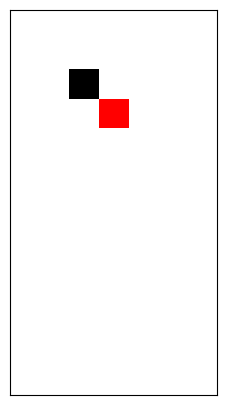

In [11]:
all_grid = model.datacollector.get_model_vars_dataframe()

color_map = {
    0: 'white',  
    1000: 'blue',   
    2000: 'red',
    3000: 'green',
    4000: 'yellow',
    5000: 'black'
}
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.colors.ListedColormap([color_map[val] for val in color_map]))

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=iterations)
anim

In [ ]:
class Server(BaseHTTPRequestHandler):
    global all_grid
    def _set_response(self):
        self.send_response(200)
        self.send_header('Content-type', 'text/html')
        self.end_headers()
        
    def do_GET(self):
        self._set_response()

        if self.path.startswith("/grid"):  # Cambia "/mi_ruta" por la ruta que desees
            # Obtener el parámetro de la URL
            param_index = self.path.find("?ite=")
                
            if param_index != -1:                
                contenido = str(height) + " " + str(width) + "\n"
                param = self.path[param_index + len("?ite="):]
                selected_row = all_grid.iloc[int(param)][0]  # Asumiendo que all_grid es un DataFrame                

                for i in range(len(selected_row)):
                    for j in range(len(selected_row[i])):
                        contenido += str(int(selected_row[i][j])) + " "
                    contenido += "\n"
                    
                #print(contenido)
                self.wfile.write(contenido.encode('utf-8'))
            else:
                self.wfile.write("GET request for {}".format(self.path).encode('utf-8'))
        elif self.path.startswith("/iterations"):            
            self.wfile.write(str(iterations).encode('utf-8'))
        else:
            self.wfile.write("GET request noche for {}".format(self.path).encode('utf-8'))

    def do_POST(self):
        self._set_response()
        self.wfile.write(str(all_grid).encode('utf-8'))

def run(server_class=HTTPServer, handler_class=Server, port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    logging.info("Starting httpd...\n")  # HTTPD is HTTP Daemon!
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:   # CTRL+C stops the server
        pass
    httpd.server_close()
    logging.info("Stopping httpd...\n")

if __name__ == '__main__':
    from sys import argv
    
    if len(argv) == 2:
        run(port=int(argv[1]))
    else:
        run()


INFO:root:Starting httpd...

127.0.0.1 - - [05/Sep/2023 15:30:42] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 16:10:53] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 16:12:23] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 16:13:14] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 16:13:57] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 16:14:57] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2023 16:14:57] "GET /grid?ite=1 HTTP/1.1" 200 -
C:\Users\yaelc\AppData\Local\Temp\ipykernel_3564\266266183.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  selected_row = all_grid.iloc[int(param)][0]  # Asumiendo que all_grid es un DataFrame
127.0.0.1 - - [05/Sep/2023 16:16:27] "GET /iterations HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/202